In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100
MIN_SIZE = 0
NUM_CORES = 22

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

In [8]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [9]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 29.1 s, sys: 900 ms, total: 30 s
Wall time: 30 s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [12]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [13]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [14]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = set(doc_classification_map[validation_doc_id]) & classifications_set
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels, dtype=np.int8)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = set(doc_classification_map[validation_doc_id]) & classifications_set
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels, dtype=np.int8)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [15]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector
    
def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    training_data = []
    training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
    for i,doc_id in enumerate(training_docs_list):
        normal_array = doc2vec_model.docvecs[doc_id]
        training_data.append(normal_array)
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        if i % 100000 == 0:
            info("Finished {} in training".format(i))
    info("doing matrix creation")
    training_data_mat = np.array(training_data)
    del training_data
    return training_data_mat, training_labels_mat

In [16]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        del self.curr_lines, self.curr_docids
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

### Doc2vec and SVM Parameters

In [26]:
SVM_ITERATIONS = 10
SVM_CONVERGENCE = 0.01
SVM_REG = 0.1
SVM_CLASS_WEIGHTS = None
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

## Multiple Validation Loop

In [27]:
classifications = valid_classes
classifications_type = 'classes'
classifier_file = TYPE_CLASSIFIER.format(classifications_type)

In [28]:
doc2vec_methods_dict = {
#     'doc2vec_size_50_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None' : 7,
#     'doc2vec_size_50_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None' : 8,
#     'doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
#     'doc2vec_size_100_w_2_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 9,
#     'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 18,
#     'doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 10,
#     'doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 4,
#     'doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 7,
#     'doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
#     'doc2vec_size_200_w_2_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 7,
#     'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 6,
#     'doc2vec_size_200_w_4_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
#     'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 14,
#     'doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 1,
#     'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
#     'doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
#     'doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 6,
#     'doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 5
}

## Actual Training, validation and Metrics Loop

In [29]:
for (doc2vec_method_name, epoch) in doc2vec_methods_dict.items():
    print '********* {} -> {}'.format(doc2vec_method_name, epoch)

    VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
    TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)

    placeholder_model_name = doc2vec_method_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = doc2vec_method_name
    
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        info("Couldnt find the doc2vec model with epoch {}".format(epoch))
        raise Exception()

    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))

    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, classifier_file)):

        info('Getting training Data')
        X, y = get_training_data(doc2vec_model, classifications)

        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)

        # Training of a classifier
        %time clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, classifier_file), 'w'))

        del X, y

    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, classifier_file), 'r'))

    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp_score, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])

    # Saving the metrics
    #     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
    #                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))

    del Xv, yv, yvp, yvp_score

2017-02-17 01:00:30,719 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


********* doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None -> 8


2017-02-17 01:00:44,384 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.* with mmap=None
2017-02-17 01:00:44,385 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.doctag_syn0.npy with mmap=None
2017-02-17 01:00:55,184 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn1neg.npy with mmap=None
2017-02-17 01:01:03,380 : INFO : loading syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn0.npy with mmap=None
2017-02-17 01:01

CPU times: user 1h 15min 54s, sys: 24min 14s, total: 1h 40min 9s
Wall time: 1h 40min 11s


2017-02-17 02:42:06,776 : INFO : Getting Validation Embeddings
2017-02-17 02:42:06,778 : INFO : ===== Loading validation vectors
2017-02-17 02:43:52,467 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 12.425, Avg Labels: 1.240, 
		 Top 1: 0.110, Top 3: 0.579, Top 5: 0.699, 
		 F1 Micro: 0.004, F1 Macro: 0.000, Total Pos: 850


In [32]:
epoch = 4

In [ ]:
%%time

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
else:
    info("Couldnt find the doc2vec model with epoch {}".format(epoch)) 


ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                         GLOBAL_VARS.SVM_MODEL_NAME))

if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                      GLOBAL_VARS.SVM_MODEL_NAME, classifier_file)):

    info('Getting training Data')
    X, y = get_training_data(doc2vec_model, classifications)

    info('Training Classifier')
    clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=0, n_jobs=1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


    # Training of a classifier
    %time clf.fit(X,y)
    pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, classifier_file), 'w'))

#     # Training Metrics
#     info('Evaluating on Training Data')
#     yp = clf.predict(X)
#     yp_score = clf.decision_function(X)
#     print yp
#     training_metrics = get_metrics(y, yp_score, yp)
#     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
#         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
#         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
#         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])
#
#     # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))

#     epoch_training_metrics.append(training_metrics)

    del X, y

else:
    info('Loading Classifier')
    clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                      GLOBAL_VARS.SVM_MODEL_NAME, classifier_file), 'r'))

# Validation Metrics
info('Getting Validation Embeddings')
Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                validation_docs_list, validation_preprocessed_files_prefix,
                                                validation_preprocessed_docids_files_prefix)
info('Evaluating on Validation Data')
yvp = clf.predict(Xv)
yvp_score = clf.decision_function(Xv)
print yvp
validation_metrics = get_metrics(yv, yvp_score, yvp)
print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
    validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])


# Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                      GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


2017-01-31 15:05:52,163 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-01-31 15:05:52,165 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model
2017-01-31 15:05:59,319 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.* with mmap=None
2017-01-31 15:05:59,320 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-31 15:06:00,067 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_sea

In [36]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(6)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2017-01-07 08:32:48,888 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-07 08:32:48,891 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model
2017-01-07 08:33:14,046 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-01-07 08:33:14,048 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-07 08:33:21,936 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_mode

## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


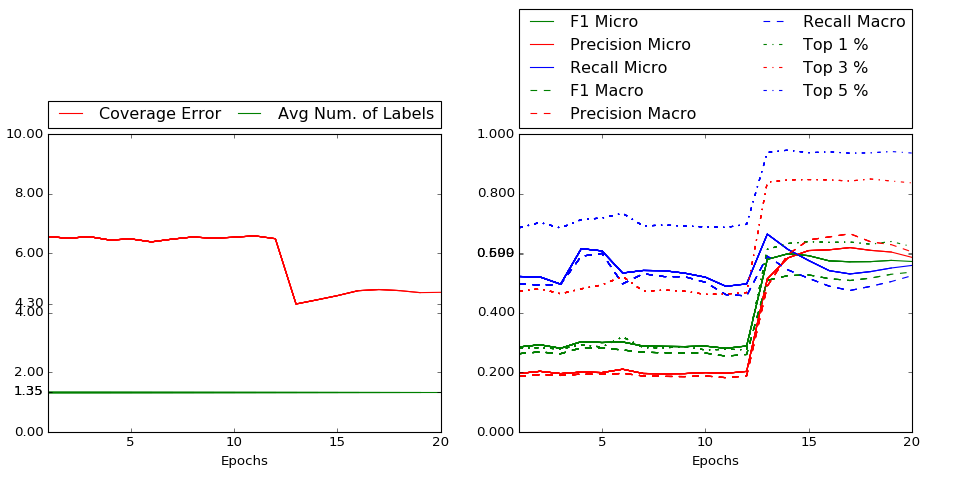

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]